<center>
## Открытый курс по машинному обучению
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9
## <center> Анализ временных рядов

In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)




def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

5.17.0


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [32]:
df.shape

(383, 7)

In [33]:
df.date = pd.to_datetime(df.date)

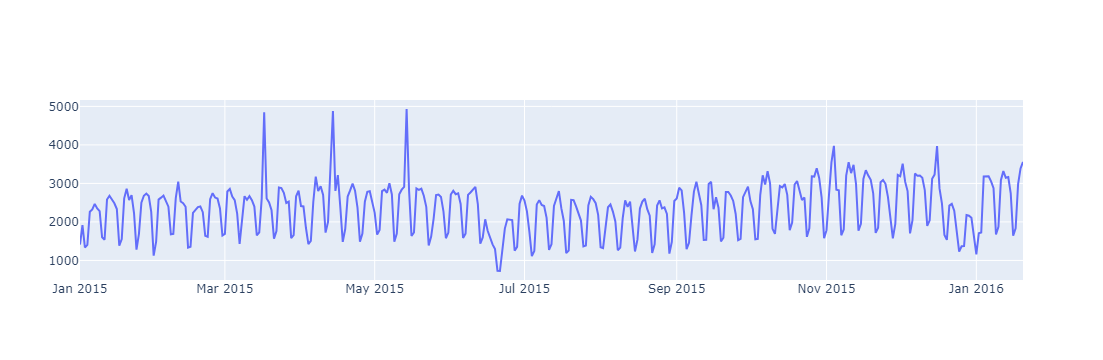

In [34]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [35]:
from prophet import Prophet

In [36]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [41]:
m = Prophet()
m.fit(train_df)

21:38:56 - cmdstanpy - INFO - Chain [1] start processing
21:38:56 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [44]:
predicts = m.predict(future)
predicts.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2975.100998,1711.372334,2539.324944,2956.170812,2994.981212,-862.545964,-862.545964,-862.545964,-862.545964,-862.545964,-862.545964,0.0,0.0,0.0,2112.555034
379,2016-01-17,2980.432400,1832.516603,2635.735065,2960.062607,3001.736820,-721.525739,-721.525739,-721.525739,-721.525739,-721.525739,-721.525739,0.0,0.0,0.0,2258.906661
380,2016-01-18,2985.763803,2837.942830,3678.041716,2964.468404,3008.461326,281.375854,281.375854,281.375854,281.375854,281.375854,281.375854,0.0,0.0,0.0,3267.139657
381,2016-01-19,2991.095205,3127.344846,3944.487636,2968.142105,3015.112318,542.213022,542.213022,542.213022,542.213022,542.213022,542.213022,0.0,0.0,0.0,3533.308227
382,2016-01-20,2996.426608,3044.930903,3833.663134,2972.452624,3021.917296,426.073193,426.073193,426.073193,426.073193,426.073193,426.073193,0.0,0.0,0.0,3422.499801


In [45]:
# 3423 человека

**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

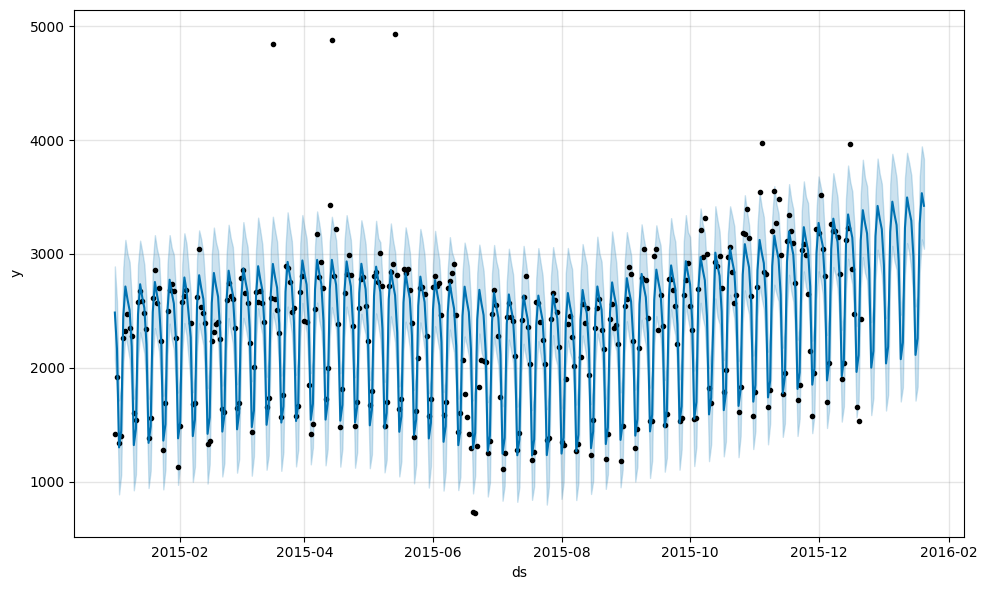

In [51]:
m.plot(predicts);

In [72]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

cmp_df = predicts.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [74]:
cmp_df.head(5)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-01-01,2484.714523,2081.399579,2889.923900,1414
2015-01-02,2167.187471,1769.873350,2585.685051,1920
2015-01-03,1300.446418,887.511880,1713.194569,1338
2015-01-04,1444.297443,1058.738560,1833.360149,1404
2015-01-05,2450.029837,2037.366691,2877.254657,2264


In [77]:
import numpy as np

cmp_df['dif'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['percent'] = 100 * cmp_df['dif'] / cmp_df['y']

print("MAPE =", np.mean(np.abs(cmp_df['percent'][-30:])))
print("MAE =", np.mean(np.abs(cmp_df['dif'][-30:])))

MAPE = 34.35047504217825
MAE = 596.7308244328995


## Предсказываем с помощью ARIMA

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

Критерий Дики-Фуллера: p=0.107392


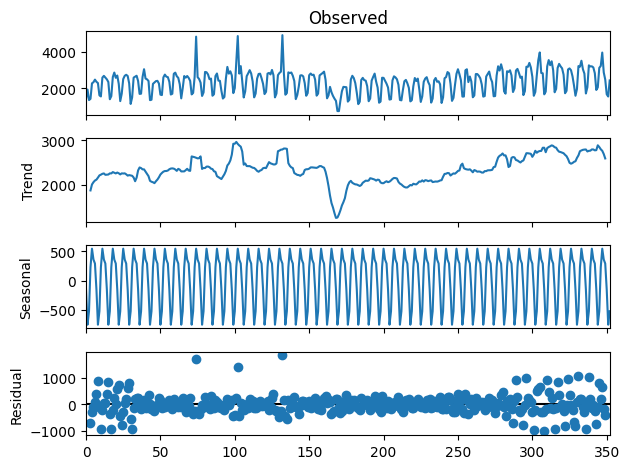

In [89]:
sm.tsa.seasonal_decompose(train_df["y"].values, period=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df["y"])[1]);

Критерий Дики-Фуллера: p=0.000000


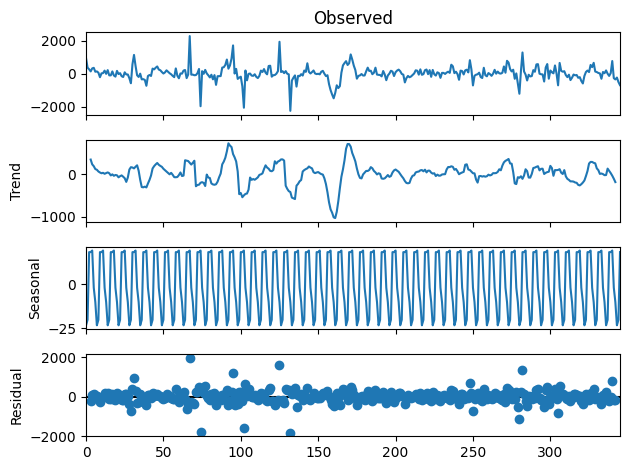

In [92]:
train_df['y_diff'] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, period=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

In [93]:
# Сезонно продифференцированный ряд - стационарен